In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
import matplotlib.pyplot as plt
from glob import glob
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error

In [2]:
ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
        
#         comb = np.concatenate((inputs, outputs), axis = 1).T
#         test = np.tile(comb,60).T
#         final = np.empty((0,51,2))
#         for i in range(60):
#             final = np.concatenate((final,test[0:inputs.shape[0],i:51+i,:]))
#         final = np.hsplit(final, [50])
#         self.inputs = final[0].astype(float)
#         self.outputs = final[1].astype(float)
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
# pa = 'palo-alto' 
# au = 'austin'
mi = 'miami'
# pi = 'pittsburgh'
# db = 'dearborn'
# dc = 'washington-dc'
split = 'train'
# train_dataset_pa = ArgoverseDataset(city = pa, split = split)
# train_dataset_au = ArgoverseDataset(city = au, split = split)
# train_dataset_pi = ArgoverseDataset(city = pi, split = split)
# train_dataset_db = ArgoverseDataset(city = db, split = split)
# train_dataset_dc = ArgoverseDataset(city = dc, split = split)
train_dataset_mi = ArgoverseDataset(city = mi, split = split)

In [3]:
batch_size = len(train_dataset_mi)
train_loader = DataLoader(train_dataset_mi, batch_size=batch_size)

In [4]:
for sample in train_loader:
    inp, out = sample
    total = torch.cat((inp,out), axis=1)
    break

In [5]:
negxnegy = []
negxposy = []
posxnegy = []
posxposy = []

In [6]:
for i in total:
    reshaped = i.reshape(220)
    if reshaped[0] <= 0 and reshaped[1] <= 0:
        negxnegy.append(reshaped)
    elif reshaped[0] <= 0 and reshaped[1] >= 0:
        negxposy.append(reshaped)
    elif reshaped[0] >= 0 and reshaped[1] <= 0:
        posxnegy.append(reshaped)
    else:
        posxposy.append(reshaped)

In [7]:
test_traj_in, test_traj_out = get_city_trajectories(city=mi, split="test")

In [8]:
import pandas as pd
sub_df = pd.DataFrame(columns = ["v" + str(i) for i in range(120)])

In [9]:
for i in range(len(test_traj_in)):
    lowest_mse = np.inf
    lowest_data = []
    reshaped = test_traj_in[i].reshape(100)
    if reshaped[0] <= 0 and reshaped[1] <= 0:
        for j in negxnegy:
            mse = mean_squared_error(reshaped,j[:100],squared=False)
            if mse < lowest_mse:
                lowest_mse = mse
                lowest_data = j[100:]
    elif reshaped[0] <= 0 and reshaped[1] >= 0:
        for j in negxposy:
            mse = mean_squared_error(reshaped,j[:100],squared=False)
            if mse < lowest_mse:
                lowest_mse = mse
                lowest_data = j[100:]
    elif reshaped[0] >= 0 and reshaped[1] <= 0:
        for j in posxnegy:
            mse = mean_squared_error(reshaped,j[:100],squared=False)
            if mse < lowest_mse:
                lowest_mse = mse
                lowest_data = j[100:]
    else:
        for j in posxposy:
            mse = mean_squared_error(reshaped,j[:100],squared=False)
            if mse < lowest_mse:
                lowest_mse = mse
                lowest_data = j[100:]
    if i % 1000 == 0:
        print(i)
    sub_df.loc[len(sub_df.index)] = np.array(lowest_data)

0
1000
2000
3000
4000
5000
6000
7000


In [10]:
sub_df

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,5920.959777,1470.352291,5920.691305,1470.335642,5920.411937,1470.318073,5920.115800,1470.298876,5919.804551,1470.277787,...,5886.552207,1469.006381,5885.780585,1468.987250,5885.111070,1468.970189,5884.549512,1468.954006,5884.100665,1468.938068
1,-7895.245217,-2190.375708,-7894.968634,-2190.374765,-7894.679807,-2190.373426,-7894.383118,-2190.372866,-7894.091000,-2190.372618,...,-7855.057851,-2188.128064,-7854.006867,-2188.096991,-7853.062656,-2188.071644,-7852.227430,-2188.050448,-7851.527531,-2188.032428
2,6274.371673,65.328707,6274.495737,65.326244,6274.620734,65.319495,6274.747175,65.315293,6274.874256,65.313788,...,6280.538063,63.420093,6280.624005,63.407306,6280.695109,63.395720,6280.754287,63.385044,6280.799990,63.375332
3,5869.630828,2328.881960,5870.774862,2329.594987,5871.922785,2330.289771,5873.081714,2330.980261,5874.217955,2331.659961,...,5932.071711,2368.202830,5932.876199,2368.737626,5933.561251,2369.192670,5934.109043,2369.563006,5934.534155,2369.848583
4,6226.264003,-89.105404,6226.103065,-89.864846,6225.943677,-90.623360,6225.785554,-91.380273,6225.628437,-92.136550,...,6218.153445,-131.297522,6218.027725,-131.925791,6217.918625,-132.474513,6217.827397,-132.937390,6217.753637,-133.312954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7966,529.756600,3314.550489,529.767537,3314.056839,529.777714,3313.548750,529.788409,3313.027713,529.800306,3312.493985,...,530.974868,3271.081930,530.986367,3270.274676,530.996001,3269.565202,531.003280,3268.961312,531.009170,3268.464521
7967,6269.657617,774.840099,6269.664241,775.420462,6269.674483,775.995636,6269.687371,776.586852,6269.703400,777.185139,...,6268.943572,805.756081,6268.932236,806.177052,6268.922023,806.539403,6268.917086,806.841545,6268.917504,807.081232
7968,600.854643,1661.332127,601.723189,1661.356121,602.625143,1661.383318,603.552158,1661.415286,604.494622,1661.452508,...,658.826817,1664.706820,659.781285,1664.761511,660.623613,1664.810991,661.346258,1664.856401,661.938848,1664.895030
7969,404.736784,3957.653388,404.808442,3958.032866,404.877196,3958.393099,404.943852,3958.731642,405.011480,3959.057823,...,406.529531,3966.530397,406.550867,3966.589615,406.568702,3966.632088,406.581040,3966.658049,406.588987,3966.669269


In [11]:
sub_df["ID"] = [str(i)+"_miami" for i in range(sub_df.shape[0])]

In [12]:
new_columns = sub_df.columns.tolist()[-1:] + sub_df.columns.tolist()[:-1]
sub_df = sub_df[new_columns]

In [13]:
sub_df.to_csv("miamiSub.csv", index=None)

In [410]:
test_point = sub_df.iloc[24].values[1:]
test_point = test_point.reshape(-1,2)

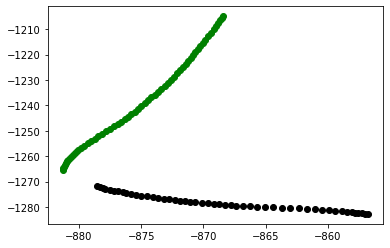

In [411]:
plt.scatter(x=test_traj_in[24,:,0], y=test_traj_in[24,:,1], color="black")
plt.scatter(x=test_point[:,0], y=test_point[:,1], color="green")

In [412]:
test_traj_in[24,:]

array([[ -856.80202059, -1282.73981786],
       [ -857.03139537, -1282.66346677],
       [ -857.29472974, -1282.56962228],
       [ -857.53896789, -1282.46456248],
       [ -857.80763298, -1282.33359514],
       [ -858.09916642, -1282.18033974],
       [ -858.46814817, -1281.98518835],
       [ -858.88249367, -1281.78470796],
       [ -859.39280732, -1281.55759277],
       [ -859.92982257, -1281.33359746],
       [ -860.47647998, -1281.12857464],
       [ -861.07132448, -1280.94053445],
       [ -861.70104559, -1280.76301017],
       [ -862.35465342, -1280.58999421],
       [ -863.05164385, -1280.42417588],
       [ -863.70630879, -1280.28722786],
       [ -864.41614385, -1280.13794917],
       [ -865.07661568, -1280.0138687 ],
       [ -865.70643907, -1279.89047426],
       [ -866.2946145 , -1279.76830216],
       [ -866.82868728, -1279.64204916],
       [ -867.35893714, -1279.46811224],
       [ -867.77718738, -1279.33255946],
       [ -868.2767569 , -1279.13075218],
       [ -868.70